# Notebook to Decompose High-Density Surface EMG

## Installing libray to provide iteractive plots

You should run this code cell below to let the plotted graphs interactive. If you run it, you must wait until the runtime restart since we are installing a library (`ipympl`) and then you are able to run all other cells.

Obs.: "Run all" cells will not be accomplished, because the `os.kill(os.getpid(), 9)` code restarsts the runtime.

If you don't desire an interactive plotted graphs you can comment or delete this first code cell and you must do the same to the commands ` %matplotlib widget `
and ` output.enable_custom_widget_manager() ` in the second code cell. If you do this, the "Run all" will work properly.

In [ ]:
import os

!pip install ipympl

os.kill(os.getpid(), 9)

## Cloning the github repository and importing libraries

In [ ]:
!git clone -l -s https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop cloned-repo
%cd cloned-repo

from dependencies import content
from google.colab import output
import ipywidgets as ipywi
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

# Enabling iteractive graphs plots
%matplotlib widget
output.enable_custom_widget_manager()

# Defining some default configurations to plot the graphs
plt.rcParams.update(
    {
        "axes.spines.top" : False,
        "axes.spines.right" : False,
        "font.size": 12,
    }
)

Cloning into 'cloned-repo'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 102 (delta 40), reused 55 (delta 23), pack-reused 0
Receiving objects: 100% (102/102), 25.66 MiB | 9.44 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/cloned-repo


## Importing HD sEMG files and identifying bad channels

### Importing HD sEMG file

Defining the `import_Mat_file( )` function that is responsible to import the HD sEMG signals saved as `.mat` files. Some considerations about how the structure of this data must be to this function works are below.

The `.mat` file must be saved as a dictionary, i.e., like below. May there be more keys and values in this dictionary, but the main keys are expressed here. We can see that inside the list corresponding to the "Data" key we have a matrix of the HD sEMG data. The preference is that the rows of this matrix are the EMG channels and the columns the sampled data, but if this is not the case, `import_Mat_file( )` function is able to identify the orientation of the matrix and let it in the preferential shape. This function provides the sampling frequency that the sigals were sampled, the time and EMG samples.

    {
        "SamplingFrequency": [2048],
        "Time": [[0.0, 0.1, ..., 50]],
        "Data": [[
                    [0.2, 1.0, ..., 38.2],
                    [-0.5, -5.0, ..., 70.6],
                    ...,
                    [1.3, 5.6, ..., -54.8]
                ]]
    }

In [ ]:
def import_Mat_file(filePath: str):

    if filePath[-4:] != ".mat":

        filePath = "".join([filePath, ".mat"])

    matFile = scio.loadmat(filePath)

    f_sampling = matFile["SamplingFrequency"][0, 0]

    time_samples = matFile["Time"][0, 0].reshape(-1)

    sEMG = matFile["Data"][0, 0]

    if sEMG.shape[1] < sEMG.shape[0]:
        sEMG = sEMG.T

    return f_sampling, time_samples, sEMG

Importing the HD sEMG signals that are stored in the `data` directory.

In [1]:
f_sampling, time_samples, sEMG = import_Mat_file("EMG and Force Data/WorkshopData/EMG_S1_05.mat")


NameError: name 'import_Mat_file' is not defined

### Identifying bad channels (manually)

Here you will see the plotted HD sEMG signals and will be able to select the channels that are considered "bad", i.e., the channels where is possible to note motion artifact. Only the selected channels will be considered in the decomposition processing. Below we are defining some functions that are responsible to show several checkboxes in a spatial format that is equal to the format of the electrode matrix used to record the HD sEMG signals. There is one function that plots all HD sEMG signals and another function that store the bad channels indexes. A brief discription of all functions is summarized:

> * `def_grid( )`: This function receives the identification of the electrodes matrix used during the recording and create an array where each element in this array correspond spatially to the respective channel in the electrode grid. To see the pin out of the grids check this [link](https://drive.google.com/file/d/1qddoypRMnP4R74OrSoXDmdO3SJUynQZk/view?usp=share_link);

> * `channels_selection( )`: This function provides interative widgets (check boxes) displayed in a saptial location that corresponds to the surface grid used during the recording of the HD sEMG signals. Moreover, this functions is responsible to keep udated the list with selected (check box checked) or not channels. Only the select channles are used in the decomposition processing;

> * `plot_channels( )`: This function will plot the HD sEMG signals whose channels are checked in the matrix of check boxes generated before. But before plotting, this function will compute a scale factor based on the mean and standard deviation of the channels. This scale factor is responsible to rescale all HD sEMG in order to avoid several overlaps of curves in the plot;

> * `define_badChannels( )`: This function identifies which channels are not selected (check box not checked) and store the channels indexes. This bad channels need to be stored and saved after the decomposition because we need to know which channel were not considered for the aferition procedure (Hands-on 2 of this workshop);

In [ ]:
def def_grid(grid_name):

    if grid_name == "ELSCH064NM4" or grid_name == "elsch064NM4":
        a = np.arange(60,65,dtype=int)
        grid = np.array([a,(a-5)[::-1],a-10,(a-15)[::-1],a-20,(a-25)[::-1],np.array([32,31,30,33,34],dtype=int),(a-35)[::-1],a-40,(a-45)[::-1],a-50,(a-55)[::-1],a-60],dtype=int)

    return grid

def channels_selection(grid):

    aux = []
    my_matrix = []
    checked_channels = {}

    i, j = grid.shape

    for row in range(i):
        aux = []
        for col in range(j):
            ch = grid[row,col]
            if ch != 0:
                check = ipywi.Checkbox(value = True, description = str(grid[row,col]),indent=False)
                checked_channels['ch'+str(ch)] = check
                aux.append(check)
            else:
                check = ipywi.Checkbox(value = False, description = '', indent=False, disabled=True,)
                check.layout.visibility = 'hidden'
                aux.append(check)

        my_matrix.append(ipywi.HBox(aux, layout = ipywi.Layout(width='25%')))

    return ipywi.VBox(my_matrix), checked_channels

def plot_channels(checked_channels):
    
    x = sEMG.mean(axis=1)

    try:
        indexes = np.unique(np.array([np.argwhere(x < x.mean()+3*x.std(ddof=1)).reshape(-1), np.argwhere(x > x.mean()-3*x.std(ddof=1)).reshape(-1)]))
        max_amp = 0
        for i in sEMG[indexes,:]:
            if abs(i.max() - i.min()) > max_amp:
                    max_amp = abs(i.max() - i.min())        
        x = sEMG * 2 / max_amp
    except:
        x = sEMG / 3

    channels = []

    i = 0
    for ii in checked_channels.values():
        if ii.value:
            channels.append(ii.description)
            i += 1
    
    channels = np.sort(np.array(channels).astype(int))

    color_markers = plt.cm.gist_rainbow(np.linspace(0,1,sEMG.shape[0]))
    c_len = len(color_markers)

    fig, (lax, ax) = plt.subplots(figsize=(17,15),nrows=2,gridspec_kw={"height_ratios":[1, 20]})

    i = 0            
    for i in range(channels.__len__()):
        ax.plot(time_samples, channels[i] + x[channels[i] - 1, :], c = color_markers[int(channels[i] % c_len)], label = "Ch " + str(channels[i]))
    plt.suptitle('Selected HD sEMG Channels', fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('EMG Channel ' + r'$(\mu V)$')

    h, l = ax.get_legend_handles_labels()
    lax.legend(h, l, loc='center', borderaxespad=0,ncol=8)
    lax.axis("off")

def define_badChannels(checked_channels):

    aux = np.array([],dtype=int)

    for ii in checked_channels.values():
        if  ii.value:
            aux = np.append(aux, int(ii.description) - 1)
    
    return np.argwhere(np.isin(np.arange(sEMG.__len__(),dtype=int), np.sort(np.unique(aux)).astype(int), invert=True)).reshape(-1)


Run both code cells below to show the grid of check boxes and the plot of the HD sEMG signals. Here you must identify from the graph the bad channels, i.e., the channels that present motion artifact. It may there be several bad channels or none. When you identify the bad channel, you should click the check box that corresponds to that channel. The not selected check boxes are considered bad channels and will not be considered during the decomposition.

In [ ]:
ui1, choosed_channels = channels_selection(def_grid("elsch064NM4"))

display(ui1)

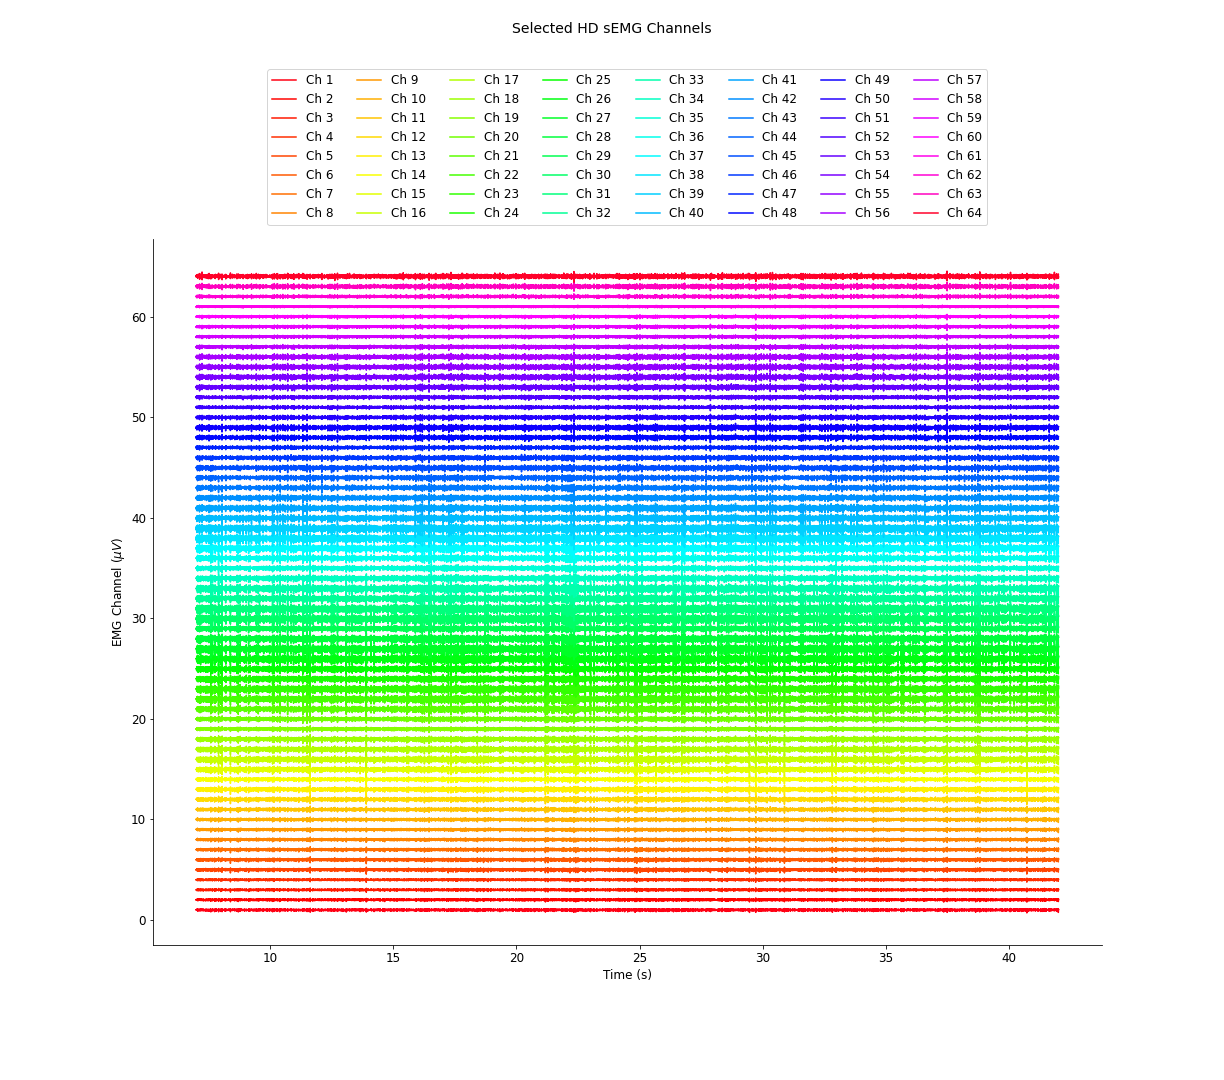

In [ ]:
plot_channels(choosed_channels)

## Pre-processing and decomposing the HD sEMG signals

After selecting the good channels, you must run the code cell below to define the list with only bad channels. This list is used in the decomposition processing and it is further provided to apply the aferition method.

In [ ]:
bad_channels = define_badChannels(choosed_channels)

### Defining the interactive menu widgets for decomposition

Below we defined some widgets that will help you set the parameters of the FastICA algrithm. You should not worry about the code below because it is not part of the decomposition itself, you just need to run it to better interact. But a brief explanation:

> * `menu_parameters( )`: This function provides five text input (just numbers allowed) widgets where you can define the values of these parameters. There are an upper and lower bound of values for each widget, and thises bounds are specified before the text input. There are two selection widgets with several options of parameters, but you can choose only one. There is a progress bar widget also, which purpose is show "how much time" passed after starting the decomposition.

In [ ]:
decompose_bar_progess = ipywi.IntProgress()

def menu_parameters(n_channels:int):

    global decompose_bar_progess

    style = {'description_width': 'initial'}
    
    w_M = ipywi.BoundedIntText(min = n_channels, max = 500, step = 1, value = 120, description='Number of Iterations (M) [' + str(n_channels) + ' - 500]: ',style=style)
    w_R = ipywi.BoundedIntText(min = 4, max = 32, step = 1, value = 10, description='Extension Factor (R) [4 - 32]: ',style=style)
    w_in = ipywi.BoundedIntText(min = 20, max = 60, step = 1, value = 30, description='Internal Loop Iterations [20 - 60]: ',style=style)
    w_Tolx = ipywi.BoundedFloatText(min = 0.00001, max = 0.01, step = 0.000001, value = 0.0023, description='FastICA Convergence [10ˉ⁵ - 10ˉ²]: ',style=style,readout_format='.6f')
    w_Sil = ipywi.BoundedFloatText(min = 0, max = 100, step = 0.1, value = 90, description='SIL Threshold (SIL [%]) [0 - 100]: ',style=style, readout_format='.1f')

    w_cf = ipywi.RadioButtons(
        description='Contrast Function g(x):',
        options=[
            'x²',
            'x³',
            '(-x) exp(-x² / 2)',
            'log(x² + 1)',
            'tanh(x)',
        ],
        layout={'width': 'max-content'},
    )

    w_winit = ipywi.RadioButtons(
        description='Initializations of wⱼ:',
        options=[
            'Maximum',
            'Median',
            '81th Percentile',
            'Random',
        ],
        layout={'width': 'max-content'},
    )

    decompose_bar_progess = ipywi.IntProgress(
            value=0,
            min=0,
            max=w_M.value,
            bar_style='success',
            orientation='horizontal',
        )

    ll1 = ipywi.link((w_M, 'value'),(decompose_bar_progess, 'max'))

    return [w_M,w_R,w_in,w_Tolx,w_Sil,w_cf,w_winit]

### Definig the contrast functions

Here we define five classes that contains distinct contrast functions that can be used in the decomposition processing. This functions are the cost functions used to compute the approximate negentropy. The defined functions are expressed below, but remember that the algorithm uses their first and second derivatives. The equation (1) was suggest in [(NEGRO et al., 2016)](https://doi.org/10.1088/1741-2560/13/2/026027), equation (3) in [(HOLOBAR; ZAZULA, 2008)](https://doi.org/10.1109/IEMBS.2008.4650254), and equations (2), (4) and (5) were suggested in [HYVÄRINEN (1999)](https://doi.org/10.1109/72.761722).

$$ G(x) = \frac{x^3}{3} \text{ } (1) $$

$$ G(x) = \frac{x^4}{4} \text{ } (2) $$

$$ G(x) = x \text{ } ln(x^2 + 1) + 2 [tan^{-1}(x) - x] \text{ } (3)$$

$$ G(x) = ln(cosh(x)) \text{ } (4) $$

$$ G(x) = exp \Big( \frac{- x^2}{2} \Big)  \text{ } (5) $$

In [ ]:
class Squared_CF:
    # G(x) = x^3/3
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        return w * w

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        return 2 * w

class Skewness_CF:
    # G(x) = x^4/4
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:

        return w * w * w

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
    
        return 3 * w * w

class Log_CF:
    # G(x) = x log(x^2 + 1) + 2 (arctan(x) - x) where log() is the natural logarithm
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return np.log(w * w +1) / np.log(10) # equals to np.log(w * w +1) / 2.302585092994046
        return np.log(w * w +1)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return 2 * w / (w * w +1) / np.log(10)
        return 2 * w / (w * w +1)

class Tanh_CF:
    # G(x) = log(cosh(x))
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return np.tanh(w) / np.log(10)
        return np.tanh(w)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return (1 - np.square(np.tanh(w))) / np.log(10)
        return (1 - np.square(np.tanh(w)))


class ExpSquared_CF:
    # G(x) = exp(- x^2 / 2)
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        return (-w) * np.exp((-1 / 2) * w * w)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        return ((w * w) - 1) * np.exp((-1 / 2) * w * w)

### Decomposition quality measures

During the decomposition processing some metrics about the quality of the estimated sources are need in order to define if the estimative is good or not. These metrics use temporal information about when a motor unit has discharged and uses the values of the estimated motor unit action potential trains at this time instants to define how much distinct these values are from the baseline noise. There are tow main metrics that can be used, the silhouette measure (SIL) used in [(NEGRO et al., 2016)](https://doi.org/10.1088/1741-2560/13/2/026027) and the pulse-to-noise ratio (PNR) defined in [(HOLOBAR; MINETTO; FARINA, 2014)](https://doi.org/10.1109/TSP.2007.896108).

So, the `PT_metrics( )` function below is responsible to identify the time instants of a motor unit action potential (MUAP) in the estimted source signal. Then, using these time instants, the corresponding voltage values of the estimated source signal (source), and the other values of the estimated source (corresponding to noise), the `PT_metrics( )` function computes both, the SIL and PNR.

In [ ]:
def PT_metrics(s_i):

    within_cluster_sum = 1
    betw_clusters_sum = 1
    pnr_numerator = 1
    pnr_denominator = 1

    s_i_squared = s_i * s_i

    peaks_timeInst, _ = find_peaks(s_i_squared, distance=20)

    peaks_squared = s_i_squared[peaks_timeInst]

    kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=400).fit(peaks_squared.reshape(-1, 1))
    centroids = kmeans.cluster_centers_
    peaks_labels = kmeans.predict(peaks_squared.reshape(-1, 1))

    MUs_timeInst = peaks_timeInst[peaks_labels == np.argmax(centroids).astype(int)]

    MUs_timeInst = np.delete(MUs_timeInst, np.argwhere(s_i[MUs_timeInst] < 0).reshape(-1))

    if MUs_timeInst.__len__() > 0:

        within_cluster_sum = 0
        betw_clusters_sum = 0

        # Getting the parameters to calculate the SIL score
        for i in range(peaks_squared.__len__()):
            within_cluster_sum += np.linalg.norm(peaks_squared[i] - centroids[peaks_labels[i], 0])
            betw_clusters_sum += np.linalg.norm(peaks_squared[i] - centroids[1 - peaks_labels[i], 0])

        # Computing the Pulse to Noise Ratio (PNR)
        pnr_numerator = s_i_squared[MUs_timeInst].mean()
        peaks_labels = np.delete(np.arange(s_i_squared.__len__(), dtype=int), MUs_timeInst)
        pnr_denominator = s_i_squared[peaks_labels].mean()

    return (
        MUs_timeInst,
        abs(within_cluster_sum - betw_clusters_sum) / max(within_cluster_sum, betw_clusters_sum),
        10 * np.log10(pnr_numerator / pnr_denominator),
    )

### Pre-processing and decomposition algorithms

Now we do all pre-processing steps that are need for the decomposition: remove the selected bad channels; extend the HD sEMG signals; center the signals; and apply the PCA and whitening. The `decompose( )` function does all the previous cited processes except for bad channels removal, this is because we created an iteractive widget block (`menu_parameters( )` function) for you choose the parameters of the algorithm, and after seted the parameters the widget block passes all the parameters values to just one function. 

The extension of the HD sEMG signals is a strategy to increase the number of observations and then, theoretically, to increase the number of estimated sources. This process is done generating R versions of each HD sEMG signal, with delays ranging from 1 to R. See the [Figure 1](#figure_1) to better understand.

<a name='figure_1'></a>
<figure align="center"><img src="assets/Extension.png" width="500"/><figcaption align = "center"> Figure 1 - Representation of extension procedure (it is an execessive representation, just for didactic purpouse).</figcaption></figure>

Another important term used in the implementation of the algorithm presented here is the activity index, a global indicator of motor unit discharge activity introduced in [(HOLOBAR; ZAZULA, 2007)](https://doi.org/10.1109/TSP.2007.896108). The study by [NEGRO et al. (2016)](https://doi.org/10.1088/1741-2560/13/2/026027) suggests to set the start point of the FastICA algorithm based on this activity index. So, the present algorithm uses four possible initial start points based on the activity index, they are:

> * Based on the argument of the activity index that corresponds to its maximum value. This was done considering the study by [NEGRO et al. (2016)](https://doi.org/10.1088/1741-2560/13/2/026027);

> * Based on the argument of the activity index that corresponds to its median value. This was done considering the study by [HOLOBAR and ZAZULA (2007)](https://doi.org/10.1109/TSP.2007.896108);

> * Based on the argument of the activity index that corresponds to its 81th percentile value. This was done considering some previous decompositions done by us (data not published);

> * Based on the argument of the activity index that corresponds to a random percentile value. This was done as being an alternative of the study by [HYVÄRINEN (1999)](https://doi.org/10.1109/72.761722) that suggests just a random initialization, but not based on some indicator;

In [ ]:
# Copying to not modify the original EMG signals
z = np.copy(sEMG)

# Removing bad channels
if bad_channels:
    z = np.delete(z, bad_channels.reshape(-1), 0)
    print("\nBad channels has been removed! New matrix shape: ", z.shape)
else:
    print("\nNo bad channels to remove!")

# INITIALIZE GLOBAL VARIABLES THAT ARE RESULTS FROM DECOMPOSITION
B = np.zeros((z.shape[0], 2), dtype=float)
Sil = np.zeros(1, dtype=float)
PNr = np.zeros(1, dtype=float)
extracted_PTs= np.zeros((1, z.shape[1]), dtype=int)
R = 10

def decompose(M,RR,max_iter,Tolx,SIL,contrastF,w_init):
    
    # Defining the global variables that will be modified inside this function
    global B, extracted_PTs, Sil, PNr, z, R

    # Initialization of variables
    R = RR
    SIL /= 100
    tolx = 1.0
    vec_norm = 0.0
    sil = 0.0
    pnr = 0.0
    n = 0
    k_0 = 0
    i = 0
    j = 1

    print("\nDecomposition total number of iterations: M = ", M)
    print("\nExtension Factor: R = ", R)
    print("\nFastICA maximum number of iterations: max_iter = ", max_iter)

    # Defining the mthod of separation vector
    print("\nMethod of initialization of separation vector: "+w_init+"!")
    if w_init == "Median" :
        vec_initi = 0.5
    elif w_init == '81th Percentile':
        vec_initi = 0.8135
    elif w_init == 'Random':
        ...
    else:
        vec_initi = 0.9999

    print("\nFastICA convergence tolerance: Tolx = ", Tolx)

    # Defining the contrast function
    print("\nDerivative of contrast function: g(x) = "+contrastF)
    if contrastF == 'x²' :
        cf = Squared_CF
    elif contrastF == 'x³':
        cf = Skewness_CF
    elif contrastF == '(-x) exp(-x² / 2)':
        cf = ExpSquared_CF
    elif contrastF == 'tanh(x)':
        cf = Tanh_CF
    else:
        cf = Log_CF

    print("\nSilhouette threshold: SIL = ", SIL)

    # Extension Procedure
    m, D_r = z.shape
    if R > 0:
        # Auxiliar matrix that represents the new extended observation matrix
        x_ = np.zeros((m * (R + 1), D_r - R))
        # Constructing the extended m(R+1)x(Dr-R) matrix x(k)
        for ch in range(m):
            for r in range(R + 1):
                x_[ch * (R + 1) + r] = z[ch, R - r : D_r - r]
    z = x_
    print("\nObservations has been extended!")

    # Centering the observations
    z = z - z.mean(axis=1).reshape(len(z), 1)
    print("\nObservations has been centered!")

    # PCA and Whitening with regularization factor
    d, U = np.linalg.eigh(np.cov(z))
    D_gamma = np.diag(1 / np.sqrt(d + np.mean(d[: round(len(d) / 2)])))
    W = np.dot(np.dot(U, D_gamma), U.T)
    z = np.dot(W, z)
    print("\nExtended observations has been whitened!")

    # Calculating the Activity Index
    indexes_gamma: np.ndarray = np.argsort((z * z).sum(axis=0), axis=0, kind="mergesort")
    len_gamma: int = indexes_gamma.__len__()

    # Initialization of variables dependent on z extended
    B = np.zeros((z.shape[0], M), dtype=float)
    BB = 0 * np.identity(z.shape[0])
    Sil = np.zeros(1, dtype=float)
    PNr = np.zeros(1, dtype=float)
    extracted_PTs= np.zeros((1, z.shape[1]), dtype=int)
    indexes_sources = np.zeros(1, dtype=int)

    decompose_bar_progess.value = 0

    print("\nDecomposing...")
    for i in range(M):

        if indexes_gamma.__len__() > 0:

            if w_init == 'Random':
                vec_initi = np.random.rand(1)

            k_0 = indexes_gamma[int(vec_initi * indexes_gamma.__len__())]

            w_new = z[:, k_0]

            """
            FastICA
            """
            n = 0
            tolx = Tolx + 1

            vec_norm = np.linalg.norm(w_new)
            if vec_norm > 0:
                w_new /= vec_norm

            while tolx > Tolx and n < max_iter:

                w_old = np.copy(w_new)

                s = np.dot(w_old, z)
                w_new = (z * cf.g(s)).mean(axis=1) - (cf.dg_dw(s).mean() * w_old)

                w_new -= np.dot(BB, w_new)

                vec_norm = np.linalg.norm(w_new)
                if vec_norm > 0:
                    w_new /= vec_norm

                tolx = abs(np.dot(w_new, w_old) - 1)

                n += 1

            B[:, i] = w_new
            BB += np.dot(w_new.reshape(-1, 1), w_new.reshape(1, -1))

            t_j, sil, pnr = PT_metrics(np.dot(w_new, z))

            if sil >= SIL:
                indexes_sources = np.append(indexes_sources, i)
                pt = np.zeros((1, z.shape[1]))
                pt[0, t_j] = 1
                Sil = np.append(Sil, sil)
                PNr = np.append(PNr, pnr)
                extracted_PTs = np.append(extracted_PTs, pt, axis=0)
            
            t_aux = np.copy(t_j)

            for j in range(1, R // 2 + 1):
                t_aux = np.append(t_aux, t_j - j)
                t_aux = np.append(t_aux, t_j + j)

            if k_0 not in t_j:
                t_aux = np.append(t_aux, np.linspace(k_0 - R // 2, k_0 + R // 2, R + 1, dtype=int))

            t_aux = t_aux[np.argwhere((t_aux >= 0) & (t_aux < len_gamma)).reshape(-1)]

            indexes_gamma = np.delete(indexes_gamma, np.argwhere(np.isin(indexes_gamma, t_aux)).reshape(-1))

            decompose_bar_progess.value += 1

        else:

            break

    
    indexes_sources = np.delete(indexes_sources, obj=0)
    Sil = np.delete(Sil, obj=0)
    PNr = np.delete(PNr, obj=0)
    extracted_PTs = np.delete(extracted_PTs, obj=0, axis=0)

    B = B[:, indexes_sources]

    print("\nFinished!\nEstimated Sources: ", extracted_PTs.shape[0])


No bad channels to remove!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


### Decomposition menu

Here we generate the menu of widgets taht was created in the `menu_parameters( )` function.

In [ ]:
ui_menu_widgets = menu_parameters(sEMG.shape[0])

int_out2 = ipywi.interact_manual(decompose,M=ui_menu_widgets[0],RR=ui_menu_widgets[1],max_iter=ui_menu_widgets[2],Tolx=ui_menu_widgets[3],SIL=ui_menu_widgets[4],contrastF=ui_menu_widgets[5],w_init=ui_menu_widgets[6])

display(ipywi.HBox([decompose_bar_progess]))

interactive(children=(BoundedIntText(value=120, description='Number of Iterations (M) [64 - 500]: ', max=500, …

## Post-processing and statistical metrics computation

### Calculating statistics and remove repeated sources

After the decompositon processing, some post-processing and analysis should be done, for example, we need to verify if there are repeated source signals, and if it is true we need to remove them. Moreover we need calculate some statistics of the interspike intervals (ISI) of each estimated source, such as, mean, standard deviation, coefficient of variation (CoV), skewness and kurtosis. This metrics are important to the experts take conclusions about the discharge characteristics. So, lets explain the defined functions below.

> * `compute_PTs_statistics( )`: This function uses the discharge times of the motor units to compute the ISIs of each estimated source. Then, using the values of ISIs of one motor unit, this function computes the mean, the standard deviation, the CoV, the skewness and kurtosis of the ISIs. If some spurious estimative occurs, i.e., if there is an estimated source with less than 3 spikes, all these metrics are considered null and the `finding_duplicates( )` function below remove these supious motor units.

> * `finding_duplicates( )`: This function is not defined because the amount of lines of code, the full explanation can be cumbersome and it is not the main aim of this workshop, but you can find it in this `cloned-repo/dependencies/content.py` file. The main ideia of this function is to compare all possible combinations of pairs of spike trains and identify if they are equal or not. To do this the function delays and advances one of the spike trains in a pre-defined time interval. This time interval is $\pm0.5 ms$ around each spike, see [(HOLOBAR et al., 2010)](https://doi.org/10.1109/TNSRE.2010.2041593), but we used an interval proportional to $R$, i.e., $\pm (R/2) ms$, since we have done the extension procedure before. Then, it counts the number of commun spikes between the two analysed spike trains, if the number of commun spikes is greater or equal than 30% of the totla number of spikes of each individual spike train, then both are considered the same source, [(HOLOBAR et al., 2010)](https://doi.org/10.1109/TNSRE.2010.2041593). The spike train whose SIL score is higher is chosen as the "true" estimative. This function returns the number of the iteration that the "true" estimated were obtained; the spike trains of the "true" estimates; some possible remained repeated sources; and a matrix where each element is a rate of agreement (RoA) between two spike trains. See [(HOLOBAR et al., 2010)](https://doi.org/10.1109/TNSRE.2010.2041593) to better understand the RoA.

In [ ]:
def compute_PTs_statistics(pts):

    cov_ = np.zeros(pts.__len__(), dtype=float)
    mean_ = np.zeros(pts.__len__(), dtype=float)
    std_ = np.zeros(pts.__len__(), dtype=float)
    skewness_ = np.zeros(pts.__len__(), dtype=float)
    kurtosis_ = np.zeros(pts.__len__(), dtype=float)

    for i in range(pts.__len__()):

        isi = np.argwhere(pts[i, :]).reshape(-1)

        if isi.__len__() >= 2:
            isi = np.diff(isi)
            mean_[i] = isi.mean() / f_sampling
            std_[i] = isi.std(ddof=1) / f_sampling
            cov_[i] = std_[i] / mean_[i]
            skewness_[i] = skew(isi)
            kurtosis_[i] = kurtosis(isi)
        else:
            mean_[i] = 0
            std_[i] = 0
            cov_[i] = 0
            skewness_[i] = 0
            kurtosis_[i] = 0

    return cov_, mean_, std_, skewness_, kurtosis_

Now is the time to apply the `compute_PTs_statistics( )` and `finding_duplicates( )`. After this procedures, we need to get the quality metrics (SIL and PNR) and statistics metrics (mean, standard deviation, CoV, skewness and kurtosis of the ISIs) that correspond only to the motor units that were not considered repeated.


In [ ]:
# Getting some statistics of the spike trains
CoV, Mean, Std, Skewness, Kurtosis = compute_PTs_statistics(extracted_PTs)

# Correcting the initial samples removed in the extension procedure
z = np.hstack((np.zeros((z.shape[0], R), dtype=float), z))
extracted_PTs = np.hstack((np.zeros((extracted_PTs.__len__(), R), dtype=int), extracted_PTs))

# FIND REPEATED MUs
unique_MUs_indexes, extracted_PTs, possible_dup_MU, RoA_matrix = content.finding_duplicates(extracted_PTs, Sil, CoV, R, f_sampling)

# Getting the values of all computed metrics just for the non-repeated spike trains
B = B[:, unique_MUs_indexes]
Sil = Sil[unique_MUs_indexes]
PNr = PNr[unique_MUs_indexes]
Mean = Mean[unique_MUs_indexes]
CoV = CoV[unique_MUs_indexes]
Std = Std[unique_MUs_indexes]
Skewness = Skewness[unique_MUs_indexes]
Kurtosis = Kurtosis[unique_MUs_indexes]


Identifying and removing duplicated Pulse Trains...


	Pulse Trains considered outliers (removed):  1 


	Pulse Trains considered duplicated (removed):  25 


	Unique Pulse Trains:  28 


	Possible Remained Duplicated MUs:  [] 



### Saving the decomposition outputs

Now, all metrics are updated so, we are going to organize and save them.

> * 1. We create a table to store the SIL measures, PNR values, mean discharge rate, values of the mean, standard deviation, CoV, skewness and kurtosis of ISIs, and the number of spike of each estimated spike train;

> * 2. We create a dictionary name `mdic1` that stores the spike trains, the estimatives of the sources, the original HD sEMG signals, a trigger signal, the time samples, the PNR values, the number of estimated motor units and the sampling frequency. This dictionay is created by this way with that specific keys, because this is the way that our `.m` code on the hands-on course 2 are structured to read the decomposition outputs and import them to the DEMUSE programm.

> * 3. As the separation matrix and the whitened extended observation matrix are not used by the DEMUSE, but they are important as well, we decided to store them in another dictionary called `mdic2`.

In [ ]:
# Creating a table with the spike trains statistics to be saved as a .csv file
csv_header = np.array(["MU #", "Sil (%)", "PNR (dB)", "DR (Hz)", "CoV_isi (%)", "Mean_isi (ms)", "StD_isi (ms)", "Skewness_isi", "Kurtosis_isi", "Nº spikes", ], dtype=object)
dataFrame = np.array(
    [np.arange(unique_MUs_indexes.__len__()) + 1,
        100 * Sil,
        PNr,
        1 / Mean,
        100 * CoV,
        1000 * Mean,
        1000 * Std,
        Skewness,
        Kurtosis,
        np.count_nonzero(extracted_PTs, axis=1),],
    dtype=object,
)
dataFrame = np.append(csv_header.reshape(1, -1), dataFrame.T, axis=0)

np.savetxt(
    "Pulse_Trains_Metrics.csv",
    dataFrame,
    delimiter=";",
    fmt="%s",
)

# Creating a dictionary with all needed data by DEMUSE
s = np.dot(B.T,z)
numberOfIPTs, duration = s.shape

trigger = np.ones(duration, dtype=int)

my_data = extracted_PTs.T
my_data = np.append(my_data, s.T, axis=1)
my_data = np.append(my_data, sEMG.T, axis=1)
my_data = np.append(my_data, trigger.reshape(-1, 1), axis=1)

mdic1 = {
    "Data": my_data,
    "Time": time_samples.reshape(-1, 1),
    "PNR": PNr.reshape(-1, 1),
    "NumberOfIPTs": numberOfIPTs,
    "SamplingFrequency": f_sampling,
    "BadChannels": bad_channels,
}

scio.savemat(
    "My_Results_Decomposition.mat",
    mdic1,
)

# Creating dictionary to store the whitened extended observation matrix and the separation matrix
mdic2 = {
    "SeparationMatrix": B.T,
    "WhitenedExtendedObservations": z.T,
}

scio.savemat(
    "Separation_and_Z_Matrices.mat",
    mdic2,
)

## Plotting the extracted spike trains

We defined a function named `plot_spikes( )` that is similiar to the function `plot_channels( )`, but now only the time instants where a MUAP occured is identified by a spike (unit value), while the other time instants that any MUAP occured are indicated as null values.

In [ ]:
def plot_spikes(spike_trains):

    color_markers = plt.cm.gist_rainbow(np.linspace(0,1,spike_trains.shape[0]))
    c_len = len(color_markers)

    fig, (lax, ax) = plt.subplots(figsize=(17,15),nrows=2,gridspec_kw={"height_ratios":[1, 20]})

    i = 0            
    for i in range(spike_trains.__len__()):
        ax.plot(time_samples, i + 0.55 + (0.9*spike_trains[i, :]), c = color_markers[int(i % c_len)], label = "MU " + str(i + 1))
    plt.suptitle('Motor Unit Spike Trains', fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('MU number')

    h, l = ax.get_legend_handles_labels()
    lax.legend(h, l, loc='center', borderaxespad=0,ncol=6)
    lax.axis("off")

plot_spikes(extracted_PTs)

## References

HOLOBAR, A.; MINETTO, M. A.; FARINA, D. Accurate identification of motor unit discharge patterns from high-density surface EMG and validation with a novel signal-based performance metric. Journal of Neural Engineering, v. 11, n. 1, p. 016008, 2014. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

HOLOBAR, A.; ZAZULA, D. On the selection of the cost function for gradient-based decomposition of surface electromyograms. Proceedings of the 30th Annual International Conference of the IEEE Engineering in Medicine and Biology Society, EMBS’08 - “Personalized Healthcare through Technology”, n. 4, p. 4668–4671, 2008. DOI: [10.1109/iembs.2008.4650254](https://doi.org/10.1109/iembs.2008.4650254).

HOLOBAR, Ales; MINETTO, Marco Alessandro; BOTTER, Alberto; NEGRO, Francesco; FARINA, Dario. Experimental Analysis of Accuracy in the Identification of Motor Unit Spike Trains From High-Density Surface EMG. IEEE Transactions on Neural Systems and Rehabilitation Engineering, v. 18, n. 3, p. 221–229, 2010. DOI: [10.1109/TNSRE.2010.2041593](https://doi.org/10.1109/TNSRE.2010.2041593).

HOLOBAR, Aleš; ZAZULA, Damjan. Multichannel blind source separation using convolution Kernel compensation. IEEE Transactions on Signal Processing, v. 55, n. 9, p. 4487–4496, 2007. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

HYVÄRINEN, Aapo. Fast and robust fixed-point algorithms for independent component analysis. IEEE Transactions on Neural Networks, v. 10, n. 3, p. 626–634, 1999. DOI: [10.1109/72.761722](https://doi.org/10.1109/72.761722).

NEGRO, Francesco; MUCELI, Silvia; CASTRONOVO, Anna Margherita; HOLOBAR, Ales; FARINA, Dario. Multi-channel intramuscular and surface EMG decomposition by convolutive blind source separation. Journal of Neural Engineering, v. 13, n. 2, p. 026027, 2016. DOI: [10.1088/1741-2560/13/2/026027](https://doi.org/10.1088/1741-2560/13/2/026027).